This notebook is intended to demo the mathematical machinery necessary to calibrate and plot the raw viking data stored in the nearby CSVs.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
filenames=np.concatenate((["recoveredcsvs/DR005289_F0000"+str(i)+".csv" for i in range(1,7)],["recoveredcsvs/DR005967_F0000"+str(i)+".csv" for i in range(1,10)],["recoveredcsvs/DR005967_F00010.csv"]))

In [4]:
filenames

array(['recoveredcsvs/DR005289_F00001.csv',
       'recoveredcsvs/DR005289_F00002.csv',
       'recoveredcsvs/DR005289_F00003.csv',
       'recoveredcsvs/DR005289_F00004.csv',
       'recoveredcsvs/DR005289_F00005.csv',
       'recoveredcsvs/DR005289_F00006.csv',
       'recoveredcsvs/DR005967_F00001.csv',
       'recoveredcsvs/DR005967_F00002.csv',
       'recoveredcsvs/DR005967_F00003.csv',
       'recoveredcsvs/DR005967_F00004.csv',
       'recoveredcsvs/DR005967_F00005.csv',
       'recoveredcsvs/DR005967_F00006.csv',
       'recoveredcsvs/DR005967_F00007.csv',
       'recoveredcsvs/DR005967_F00008.csv',
       'recoveredcsvs/DR005967_F00009.csv',
       'recoveredcsvs/DR005967_F00010.csv'], dtype='<U33')

Somewhat confusingly, the native format of the Viking 1 data is subtracted from 512, that is to say, upside down. Further, the native format for Viking 2 data is back-to-front, that is, high voltage at the end.

In [140]:
# Does not include the engineering data, which is obvious enough in the raw CSV
def getRawData(VikingMission,sampleIndex):
    if VikingMission==1:
        if 0<sampleIndex<7:
            return 512-np.genfromtxt(filenames[sampleIndex-1],delimiter=',')[:,:3840]
        else:
            return "Error, Viking 1 sampleIndex must be between 1 and 6."
    elif VikingMission==2:
        if 0<sampleIndex<11:
            return np.genfromtxt(filenames[sampleIndex+5],delimiter=',')[:,-1:-3841:-1]
        else: 
            return "Error, Viking 2 sampleIndex must be between 1 and 10."
    else: 
        return "Error, VikingMission must be either 1 or 2."

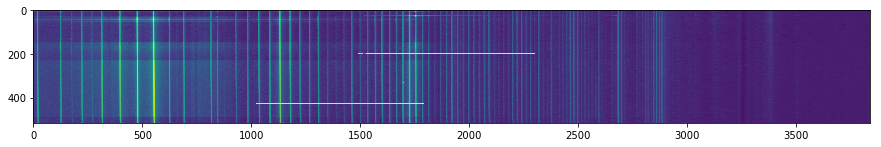

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(getRawData(1,1))

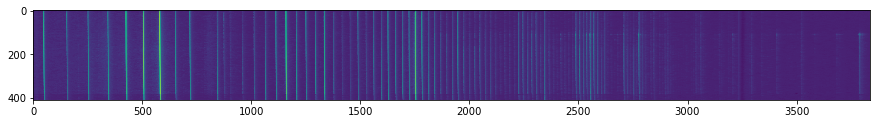

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(getRawData(2,1))

According to the papers, the mass spectrometer performs exponential reductions in voltage from about 2300V to about 125V in 3840 steps, spanning masses from 12 to 215 AMU. In a mass spectrometer, the voltage is inversely proportional to mass, so in the graph above, mass is increasing from left to right.

Essentially the horizontal axis is logarithmic in mass.

The difficulty is that not all the graphs start from precisely the same voltage. That means that the calibration needs to locate the height of the first peak.

In [118]:
def findPeakIndex(data):
    return np.dot([i for i in range(len(data))],data)/np.sum(data)

def getCalibration(whichViking,sampleIndex):
    # Use exponentiation so weighted sum is meaningful
    calibration=2**(0.1*np.mean(getRawData(whichViking,sampleIndex),axis=0))
    peak12coarse = np.where(calibration[:100]==np.max(calibration[:100]))[0][0]
    peak44coarse = np.where(calibration[1500:2000]==np.max(calibration[1500:2000]))[0][0]+1500
    peak12loc = findPeakIndex(calibration[:peak12coarse+20])
    peak44loc = findPeakIndex(calibration[peak44coarse-10:peak44coarse+10])+peak44coarse-10
    #print(peak12loc)
    #print(peak18loc)
    logm0 = (peak44loc*np.log(12.0)-peak12loc*np.log(44.0))/(peak44loc-peak12loc)
    logvs = (np.log(44.0)-logm0)/peak44loc
    return [logm0,logvs]

def MassToIndex(mass, calibration):
    return (np.log(mass) - calibration[0])/calibration[1]

def IndexToMass(index, calibration):
    return np.exp(calibration[1]*index+calibration[0])

def getHorizontalAxisInMass(whichViking,sampleIndex):
    cali = getCalibration(whichViking,sampleIndex)
    return np.array([IndexToMass(i,cali) for i in range(3840)])

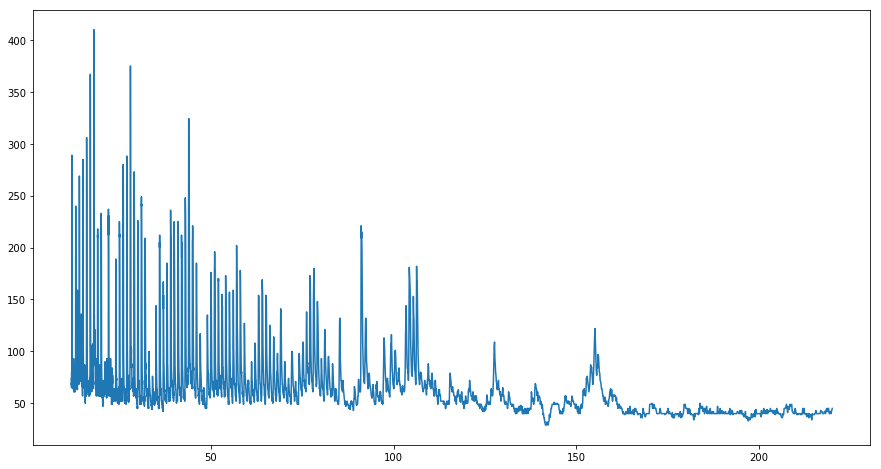

In [126]:
plt.figure(figsize=(15,8))
plt.plot(getHorizontalAxisInMass(1,1),getRawData(1,1)[2])

This shows just the first few peaks, to check that the automatic horizontal calibration lines up well.

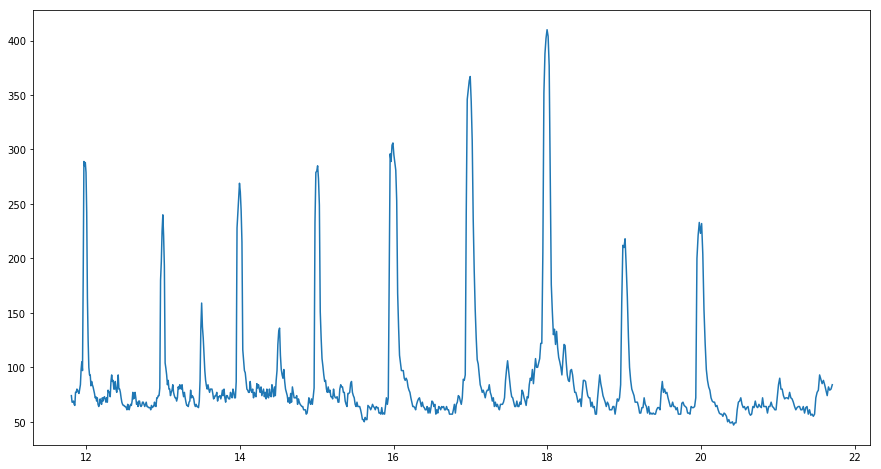

In [125]:
plt.figure(figsize=(15,8))
plt.plot(getHorizontalAxisInMass(1,1)[:800],getRawData(1,1)[2,:800])

Let's say we're interested in the perchlorate ion with a mass of 99.451. Here's a nice little function that selects all the data between two integer mass values and plots it.

In [121]:
def plotMassSpecInRange(massOfInterest,whichViking,whichSample):
    cali = getCalibration(whichViking,whichSample)
    percrange=[int(np.floor(MassToIndex(np.floor(massOfInterest), cali))),int(np.ceil(MassToIndex(np.ceil(massOfInterest), cali)))]
    xAxis=[IndexToMass(index, cali) for index in range(percrange[0],percrange[1])]
    plt.plot(xAxis,getRawData(1,1)[2,percrange[0]:percrange[1]])

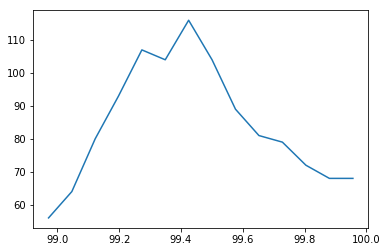

In [122]:
plotMassSpecInRange(99.451,1,1)

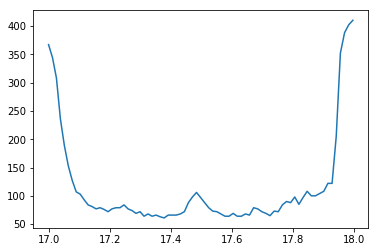

In [123]:
plotMassSpecInRange(17.451,1,1)

Finally, the vertical scale is actually logarithmic in ion current, so to get the absolute count we need to invert the logarithm and apply some multiplicative constant (the net ion current) which is probably hidden in the engineering data somewhere, or can be reverse engineered by comparison with the compressed files.

Experimentally, I have found that 2^(0.03 x rawvalue) gives about the right magnitudes. I don't know exactly which log scale the current was transformed on.

In [145]:
def plotAbsoluteScales(whichViking,whichSample,whichScan):
    cali = getCalibration(whichViking,whichSample)
    xAxis=[IndexToMass(index, cali) for index in range(3840)]
    mask=np.concatenate((np.zeros(int(np.round(MassToIndex(47,cali)))),1+np.zeros(3840-int(np.round(MassToIndex(47,cali))))))
    xAxis = getHorizontalAxisInMass(whichViking,whichSample)
    rawData = getRawData(whichViking,whichSample)[whichScan]
    
    plt.figure(figsize=(15,4))
    plt.plot(xAxis,2**(0.03*rawData))
    plt.plot(xAxis,30*mask*2**(0.03*rawData))

It is probable that the microfilms of the mass spectra were binned according to mass, but I don't know for sure. Below, I show graphs similar to the mass spectra for the entire Viking raw dataset.

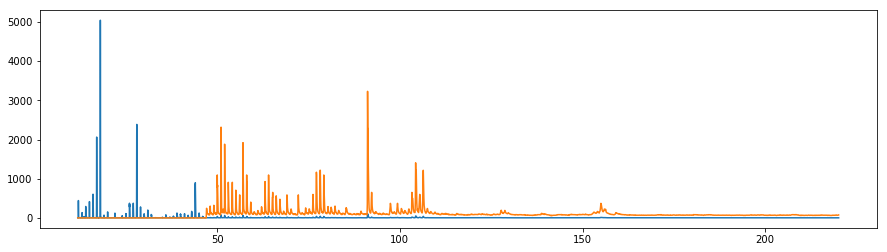

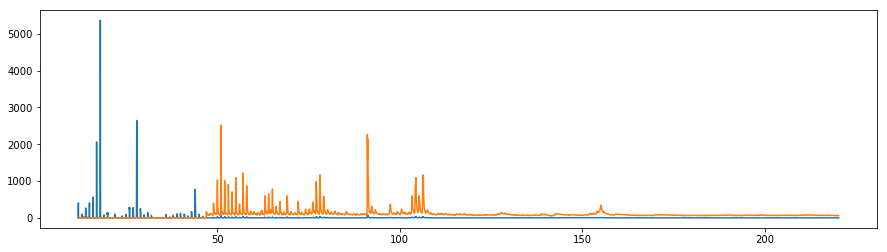

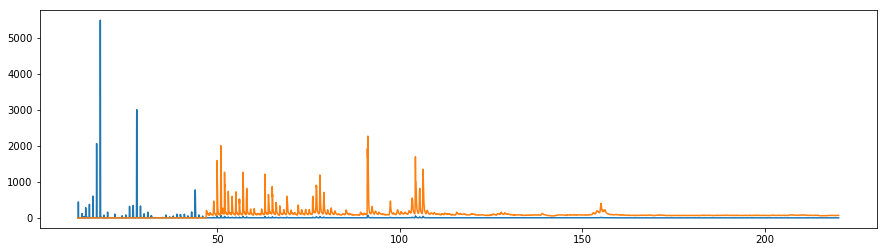

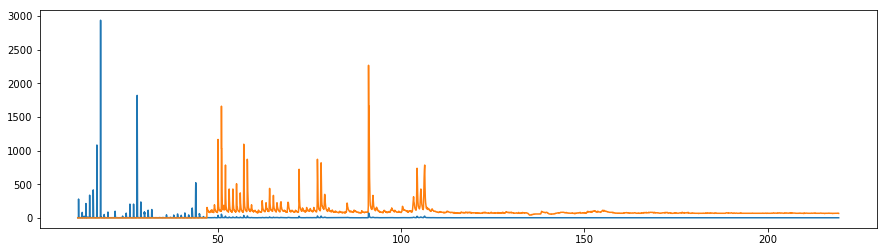

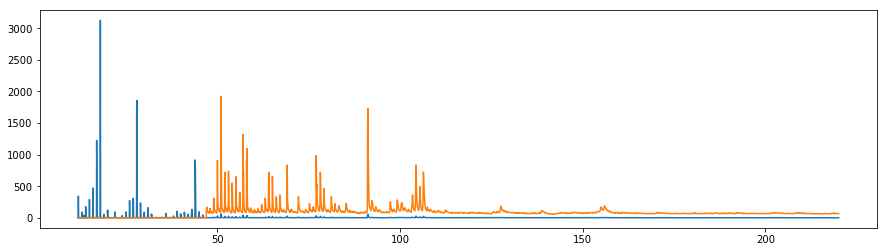

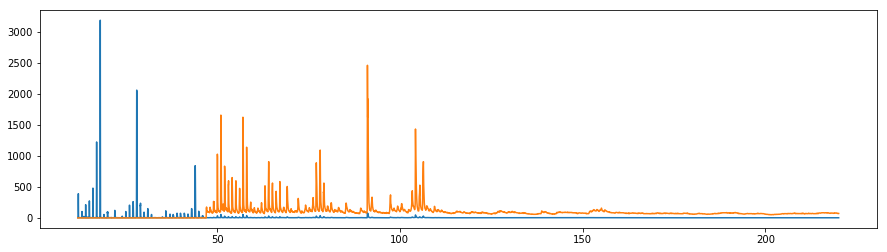

In [135]:
for index in range(1,7):
    plotAbsoluteScales(1,index,1)

The Viking 2 data is a bit different. 

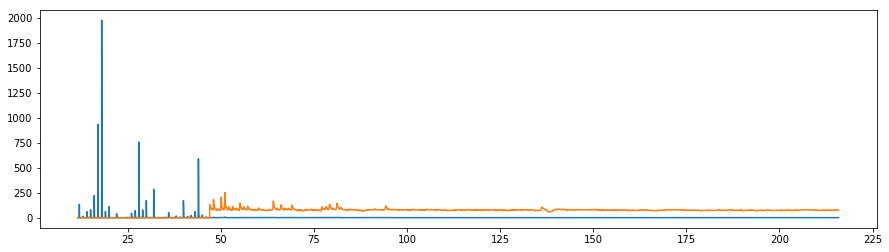

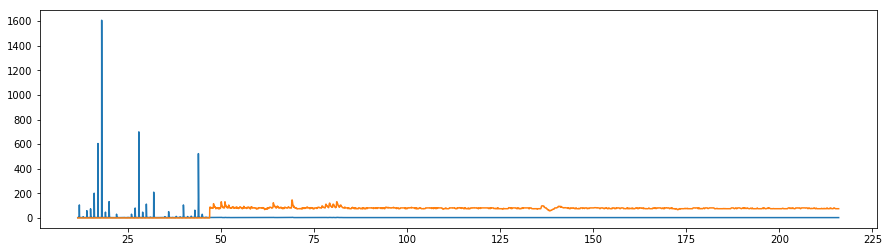

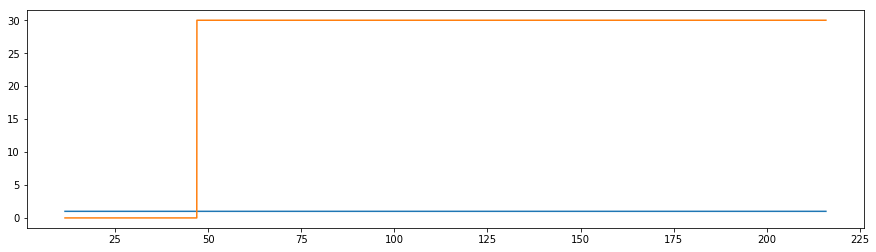

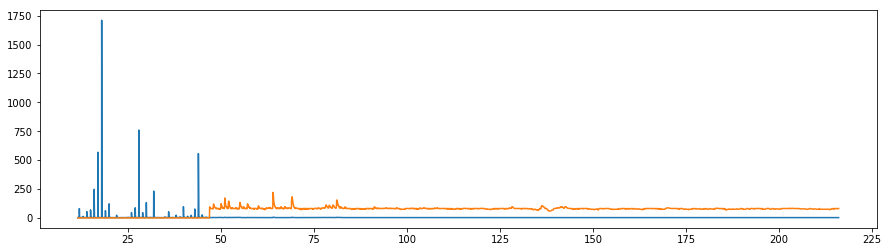

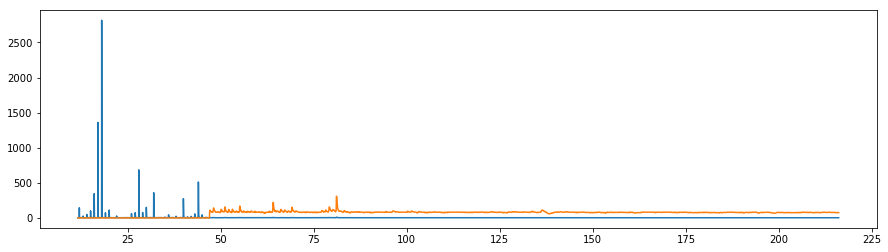

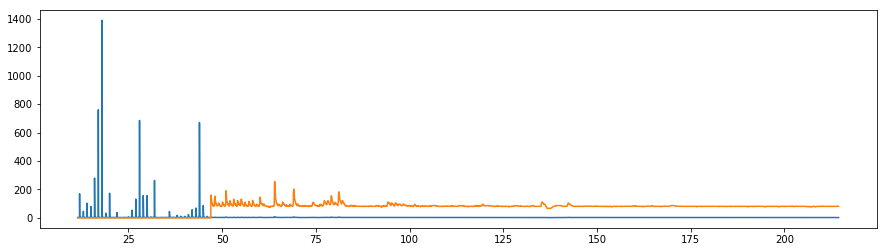

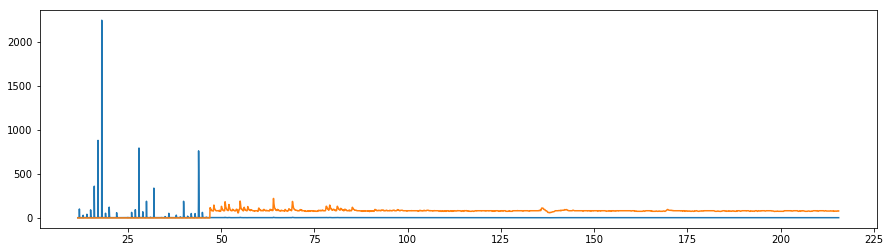

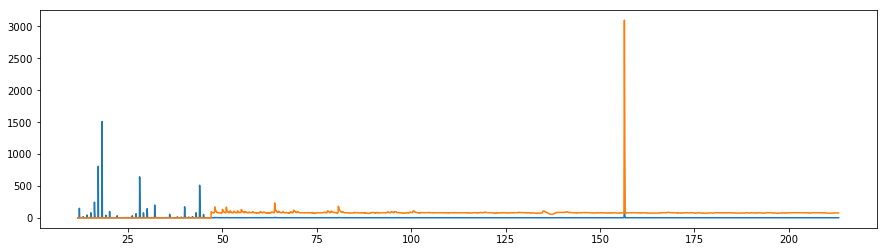

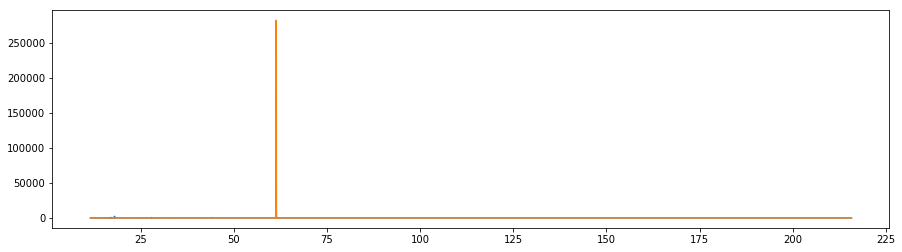

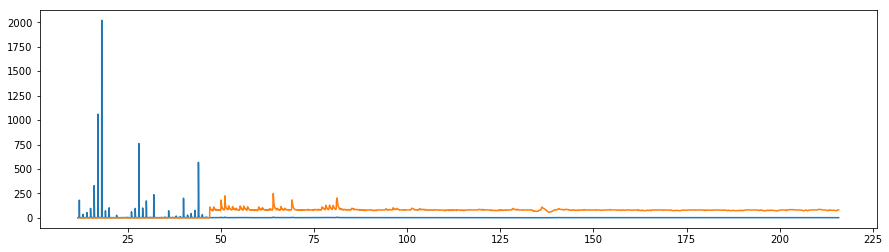

In [146]:
for index in range(1,11):
    plotAbsoluteScales(2,index,2)